In [25]:
from src.partition import Partition
from src.generators import PartitionClass
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import (
    Dense, Conv2D, Flatten, 
    ConvLSTM2D, BatchNormalization,
    Conv3D, Input, MaxPooling2D, UpSampling2D, Lambda
)
from keras.utils import plot_model
from keras.callbacks.callbacks import EarlyStopping, ReduceLROnPlateau
import keras

In [2]:
n = 28

In [3]:
training_partitions = [p for p in PartitionClass(n).partitions]
training_matrices = [p.matrix for p in training_partitions]
training_targets = [p.oblak.matrix for p in training_partitions]

X = np.array(training_matrices).reshape(-1, n, n, 1)
y = np.array(training_targets).reshape(-1, n, n, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# VAE

In [28]:
input_img = Input(shape=(n, n, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

model = Model(input_img, decoded)
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 8)           0   

In [29]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size=10, workers = 4)

Train on 2788 samples, validate on 930 samples
Epoch 1/1000
2788/2788 [==============================] - 5s 2ms/step - loss: 0.0528 - accuracy: 0.9846 - val_loss: 0.0195 - val_accuracy: 0.9917
Epoch 2/1000
2788/2788 [==============================] - 5s 2ms/step - loss: 0.0184 - accuracy: 0.9920 - val_loss: 0.0180 - val_accuracy: 0.9924
Epoch 3/1000
2788/2788 [==============================] - 5s 2ms/step - loss: 0.0160 - accuracy: 0.9931 - val_loss: 0.0143 - val_accuracy: 0.9938
Epoch 4/1000
2788/2788 [==============================] - 5s 2ms/step - loss: 0.0137 - accuracy: 0.9941 - val_loss: 0.0127 - val_accuracy: 0.9947
Epoch 5/1000
2788/2788 [==============================] - 5s 2ms/step - loss: 0.0124 - accuracy: 0.9947 - val_loss: 0.0117 - val_accuracy: 0.9951
Epoch 6/1000
2788/2788 [==============================] - 5s 2ms/step - loss: 0.0116 - accuracy: 0.9950 - val_loss: 0.0116 - val_accuracy: 0.9950
Epoch 7/1000
2788/2788 [==============================] - 5s 2ms/step - loss:

KeyboardInterrupt: 

In [28]:
z_mean

<tf.Tensor 'z_mean_1/BiasAdd:0' shape=(None, 2) dtype=float32>

In [7]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [8]:
np.reshape(X_train, [-1, n*n]).shape

(2788, 784)

In [9]:
X_train = X_train.reshape((-1, n*n))
y_train = y_train.reshape((-1, n*n))
X_test = X_test.reshape((-1, n*n))
y_test = y_test.reshape((-1, n*n))

In [10]:
image_size = n
original_dim = n * n

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_2[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_2[0][0]                    
____________________________________________________________________________________________

In [21]:
models = (encoder, decoder)
data = (X_test, y_test)

reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam', metrics = ['accuracy'])
vae.summary()
plot_model(vae,
           to_file='vae_mlp.png',
           show_shapes=True)

vae.fit(X_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_test, None))

/Users/brian/.virtualenvs/analytics/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________
Train on 2788 samples, validate on 930 samples
Epoch 1/50
2788/2788 [==============================] - 1s 224us/step - loss: 65.1855 - val_loss: 64.0990
Epoch 2/50
2788/2788 [==============================] - 0s 119us/step - loss: 64.2218 - val_loss: 64.3861
Epoch 3/50
2788/2788 [==============================] - 0s 119us/step - loss: 64.2455 - val_loss: 64.1996
Epoch 4/50
2788/27

In [47]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    X_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(X_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], )#c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "partitions_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 10
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    
    plt.figure(figsize=(n * 10, n * 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

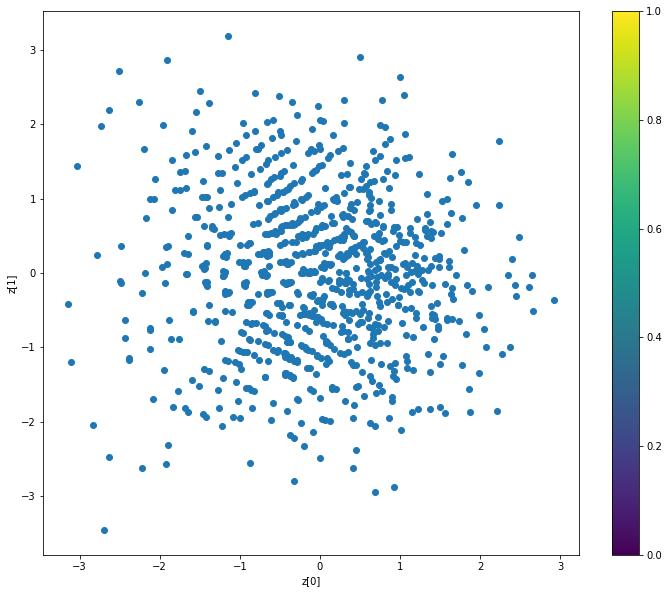

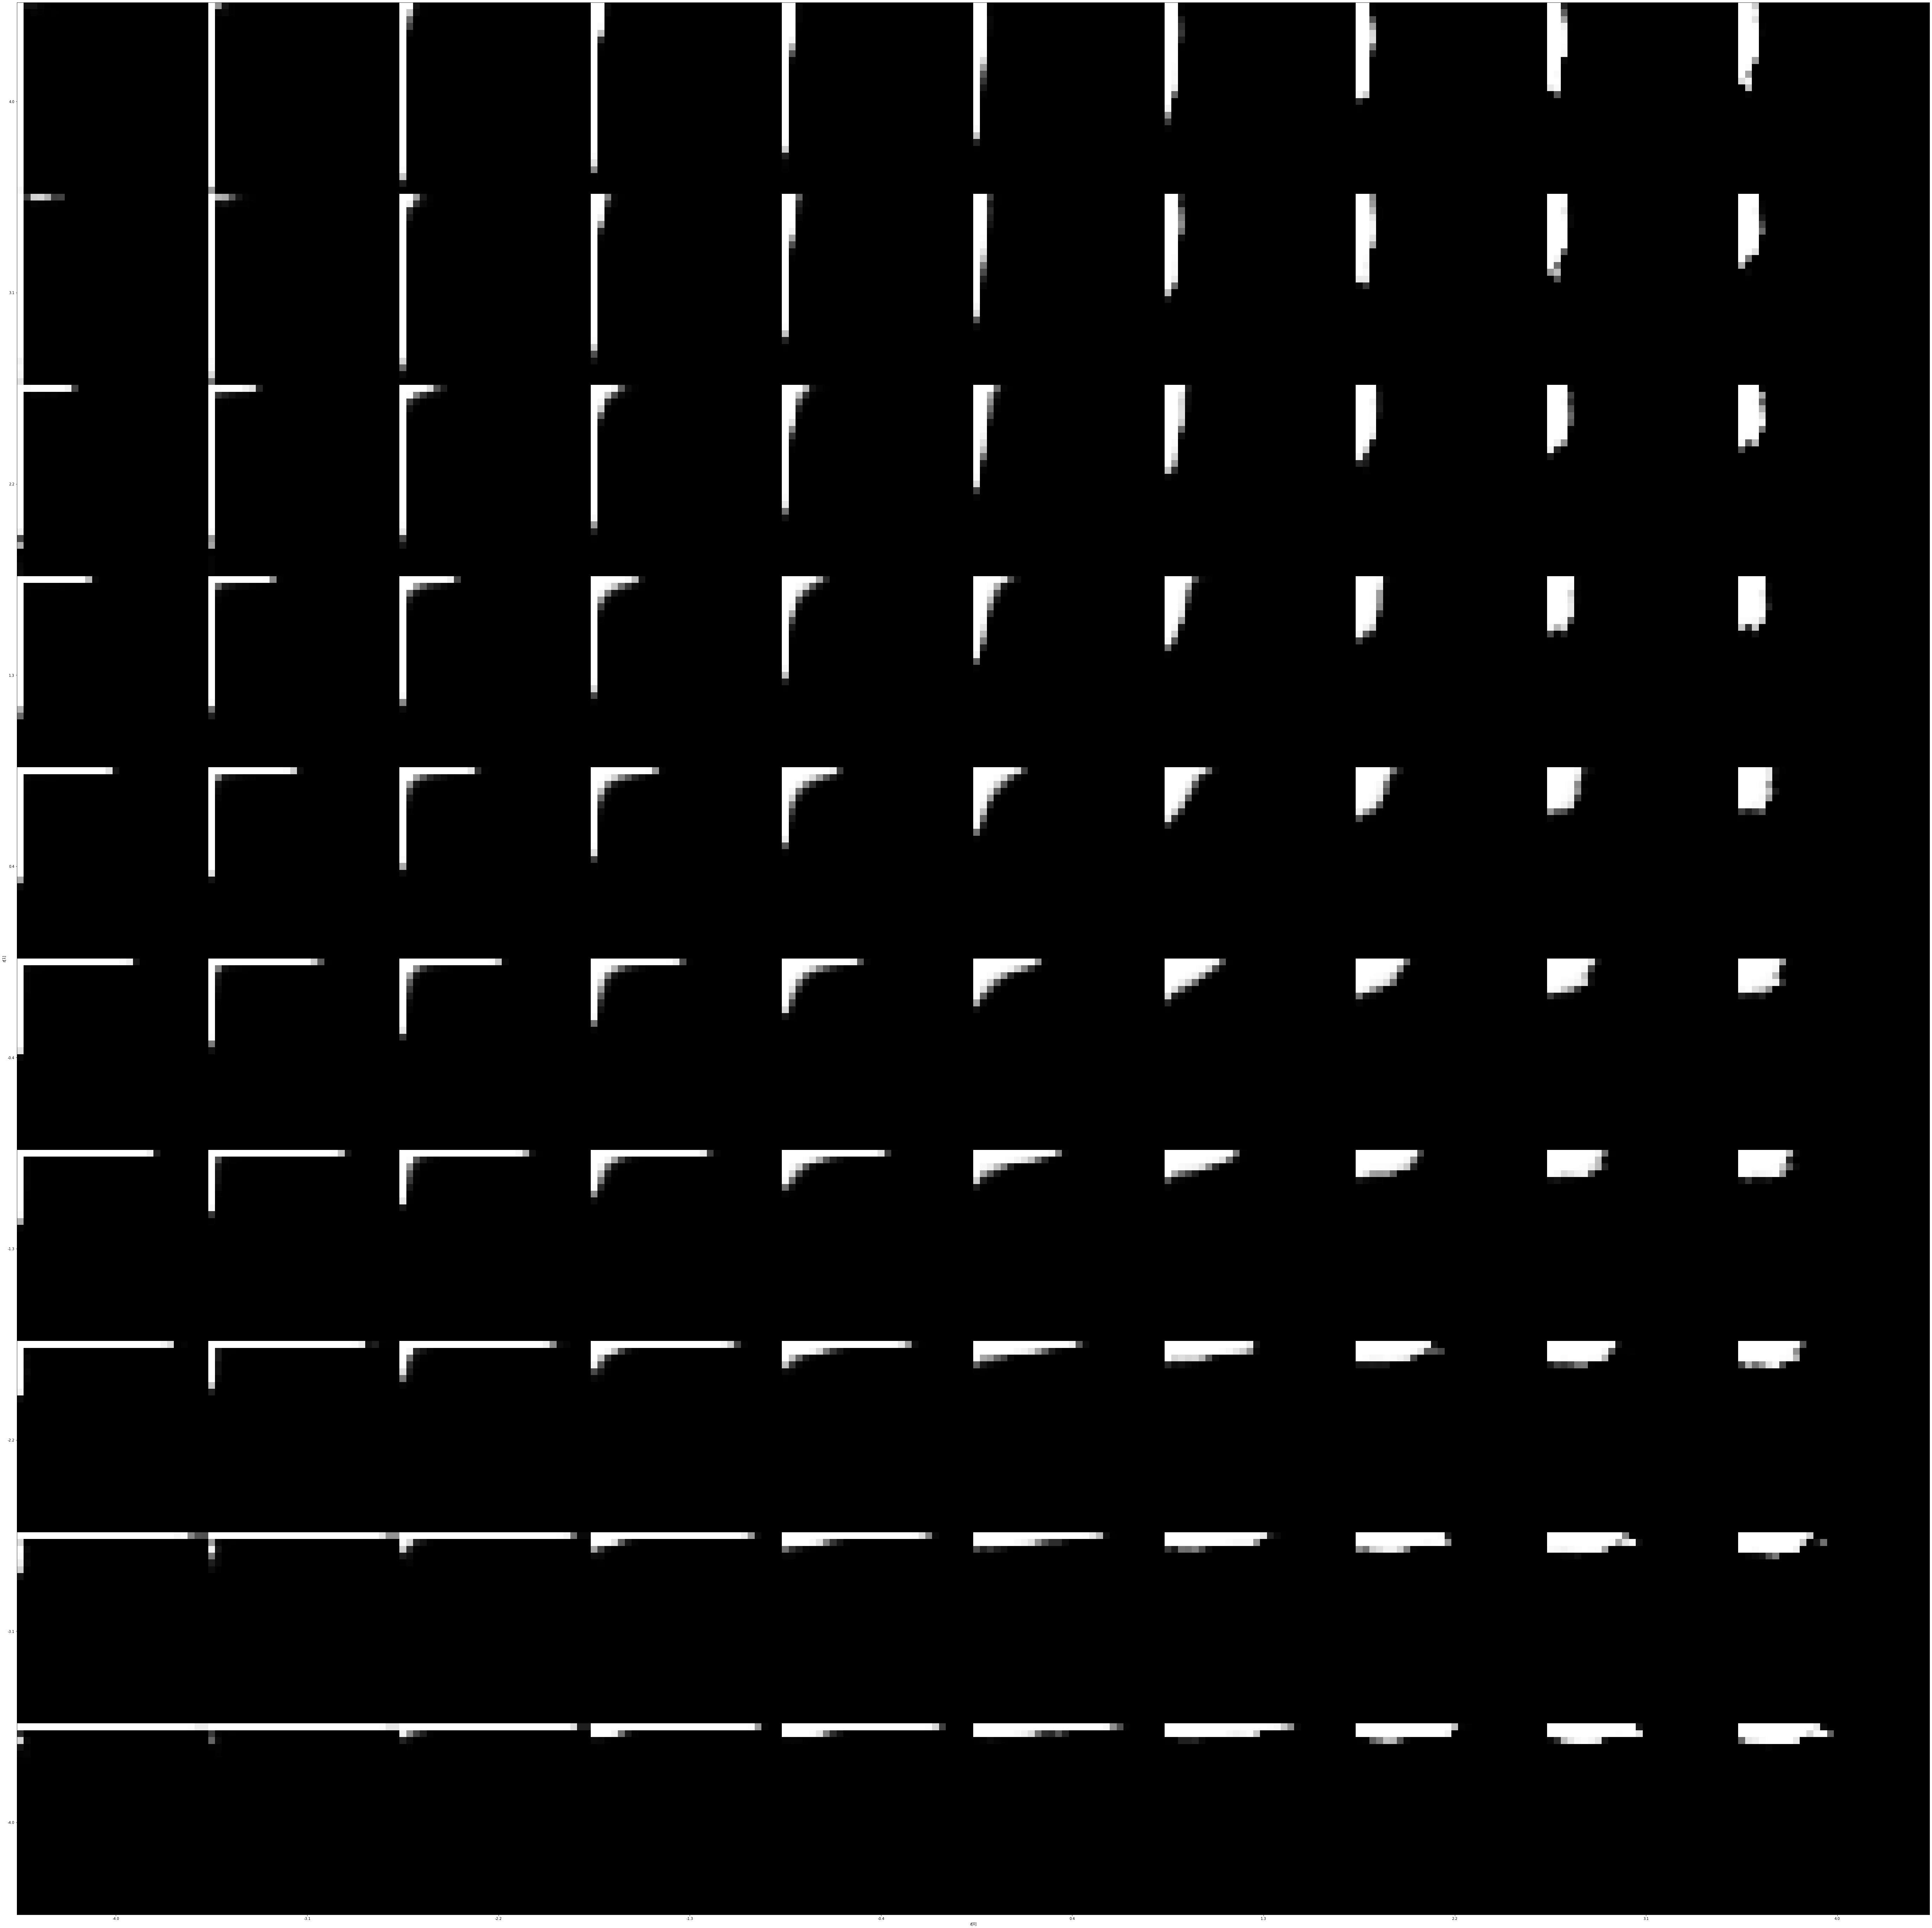

In [48]:
plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")